# **5509 Final Project: Predicting CO2 Emissions by Car Features**


**As greenhouse gas emissions continue to fuel climate change and both companies and individuals become more conscious to their carbon footprints, it is important to bring awareness to how everyday choices can impact the planet. According to the Environmental Protection Agency (EPA), light-duty vehicles [produced almost 16%](https://www.epa.gov/greenvehicles/fast-facts-transportation-greenhouse-gas-emissions) of total carbon dioxide (CO2) emissions in the United States in 2022. Learning what features impact fuel consumption can provide an easy way for consumers to make smarter choices when purchasing their next vehicle, and it can also help automotive companies predict emissions when discussing new vehicle ideas.**

**This project explores how different features, including fuel consumption and vehicle class, impact the amount of CO2 emissions a car produces. I will train multivariate regression models to predict the CO2 emissions of a vehicle based on the features and select the best model that can inform decisions moving forward. The Github repository with this notebook, the data, an html file of the output, and the video presentation/slides is available at: https://github.com/zoeh66/5509FinalProject**

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

## **Data import and cleaning**

**For this project, I am using a dataset from the Government of Canada on fuel consumption ratings for 2024 vehicles, which was published on Sept. 11, 2024. The data as a csv file can be accessed [here](https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64#wb-auto-6).**

**While this dataset is relatively clean already, I did complete a couple of tasks before moving on to the exploratory data analysis. First, I checked data types and looked for any N/A values that could impact my analysis. I dropped the model year column since the value is 2024 for every observation in the dataset. I also removed the spaces, parentheses, and slashes in all of the column names to make them easier to use in regression formulas later.**

**Because I want to use the fuel economy variable in miles per gallon (mpg) rather than in liters per 100 kilometers (L/100 km), I dropped the three unnecessary columns with the incorrect units. I also wanted to convert the CO2 emissions variable from gram per kilometer to gram per mile to make the analysis more consistent with the mpg metric. I created a new column, CO2 emissions (g/mi), and converted the original emissions field to the new units before dropping it.**

In [3]:
# Import csv file
car = pd.read_csv('2024_Fuel_Consumption_Ratings.csv')

# View dataset
print(car.info())
car.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model year            768 non-null    int64  
 1   Make                  768 non-null    object 
 2   Model                 768 non-null    object 
 3   Vehicle class         768 non-null    object 
 4   Engine size (L)       768 non-null    float64
 5   Cylinders             768 non-null    int64  
 6   Transmission          768 non-null    object 
 7   Fuel type             768 non-null    object 
 8   City (L/100 km)       768 non-null    float64
 9   Highway (L/100 km)    768 non-null    float64
 10  Combined (L/100 km)   768 non-null    float64
 11  Combined (mpg)        768 non-null    int64  
 12  CO2 emissions (g/km)  768 non-null    int64  
 13  CO2 rating            768 non-null    int64  
 14  Smog rating           768 non-null    int64  
dtypes: float64(4), int64(6)

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
0,2024,Acura,Integra A-SPEC,Full-size,1.5,4,AV7,Z,8.1,6.5,7.4,38,172,6,7
1,2024,Acura,Integra A-SPEC,Full-size,1.5,4,M6,Z,8.9,6.5,7.8,36,181,6,6
2,2024,Acura,Integra Type S,Full-size,2.0,4,M6,Z,11.1,8.3,9.9,29,230,5,6
3,2024,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,4,5
4,2024,Acura,MDX SH-AWD Type S,Sport utility vehicle: Standard,3.0,6,AS10,Z,13.8,11.2,12.4,23,291,4,5


In [4]:
# Drop model year and L/100 km fuel economy
car = car.drop('Model year', axis=1)
car = car.drop('City (L/100 km)', axis=1)
car = car.drop('Highway (L/100 km)', axis=1)
car = car.drop('Combined (L/100 km)', axis=1)
car = car.dropna()

# Convert emissions to grams per mile
car['CO2 emissions (g/mi)'] = car['CO2 emissions (g/km)'] / 0.6213712
car = car.drop('CO2 emissions (g/km)', axis=1)

# Remove spaces and parentheses from column names
car = car.rename(columns=lambda x: x.replace(' ', '_'))
car = car.rename(columns=lambda x: x.replace('(', ''))
car = car.rename(columns=lambda x: x.replace(')', ''))
car = car.rename(columns=lambda x: x.replace('/', ''))

# View cleaned and updated dataset
car.head()

,Make,Model,Vehicle_class,Engine_size_L,Cylinders,Transmission,Fuel_type,Combined_mpg,CO2_rating,Smog_rating,CO2_emissions_gmi
0,Acura,Integra A-SPEC,Full-size,1.5,4,AV7,Z,38,6,7,276.807165
1,Acura,Integra A-SPEC,Full-size,1.5,4,M6,Z,36,6,6,291.291260
2,Acura,Integra Type S,Full-size,2.0,4,M6,Z,29,5,6,370.149115
3,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6,AS10,Z,25,4,5,423.257467
4,Acura,MDX SH-AWD Type S,Sport utility vehicle: Standard,3.0,6,AS10,Z,23,4,5,468.319098


## **Exploratory data analysis**

**I began this analysis with a histogram of the target variable, CO2 emissions (g/mi), and a few scatter plots between the CO2 emissions and other variables to check for potential relationships. The distribution of CO2 emissions looks good, although there are a couple of high values that appear to be outliers. After confirmind with a boxplot, I removed the five points with CO2 emissions higher than 700 g/mi to avoid any complications later.**

**Based on the scatter plots, I will likely have to explore transforming the Combined (mpg) fuel economy variable further because it appears to have an inverse relationship with CO2 emissions. I also might try transforming the Engine Size (L) variable because it appears that it could have a nonlinear relationship with CO2 emissions as well.**

**Two variables with red flags from the correlation matrix are Cylinders and CO2 rating. It appears as though the number of cylinders in the engine is highly correlated with engine size, which makes sense because engines gain more capacity with more cylinders. I will evaluate as I go but will likely exclude the Cylinders variable in favor of Engine Size (L) to avoid any multicollinearity in my models. The near-perfect correlation between CO2 emissions and the CO2 rating also makes sense because the rating is likely a score assigned by binning the CO2 emissions total. Since it is not informative in any way, I will also exclude this variable from any models I build.**

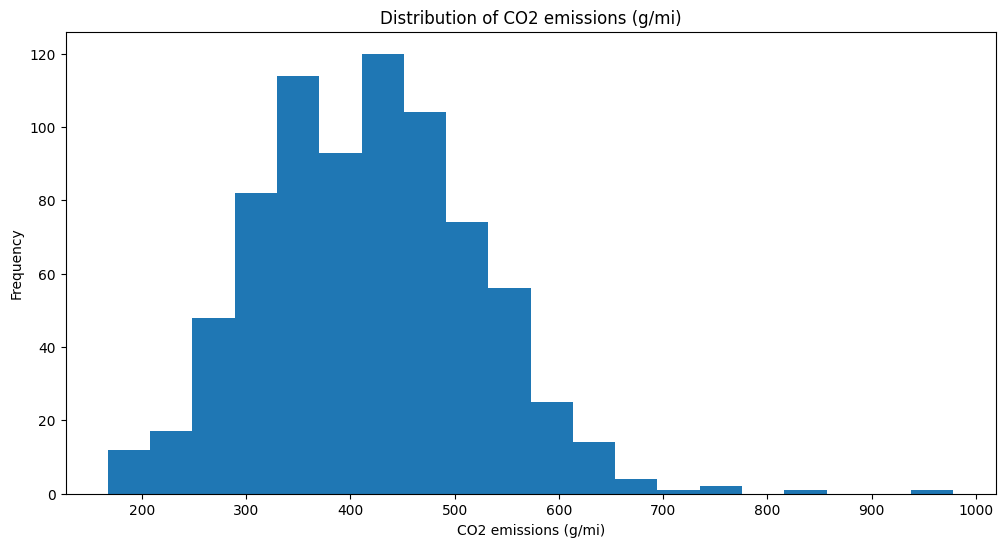

In [5]:
# Histogram of CO2 emissions (g/mi)
plt.figure(figsize=(12, 6))
plt.hist(car['CO2_emissions_gmi'], bins=20)
plt.xlabel('CO2 emissions (g/mi)')
plt.ylabel('Frequency')
plt.title('Distribution of CO2 emissions (g/mi)')
plt.show()

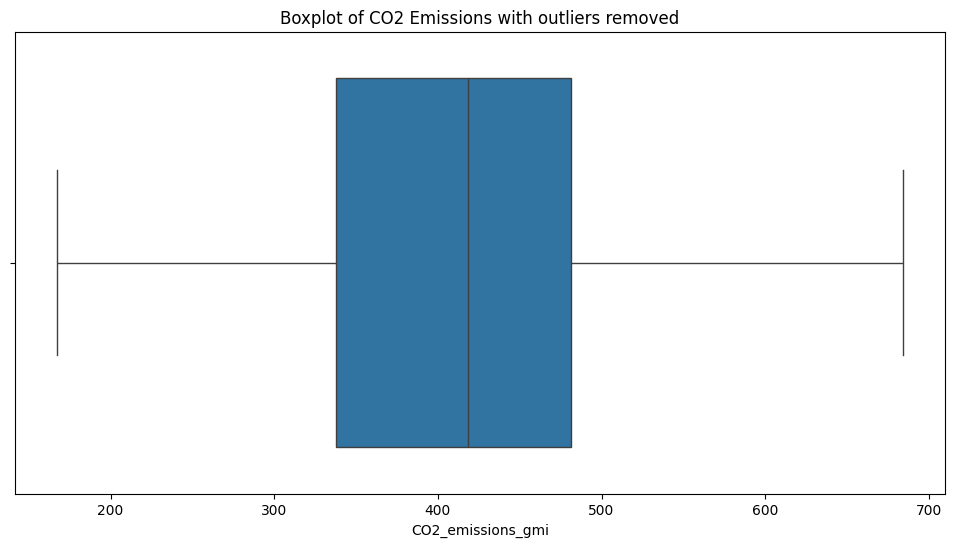

In [6]:
# Remove outliers in CO2 emissions identified above
car = car[car['CO2_emissions_gmi'] < 700]

plt.figure(figsize=(12, 6))
sns.boxplot(x='CO2_emissions_gmi', data=car)
plt.title('Boxplot of CO2 Emissions with outliers removed')
plt.show()

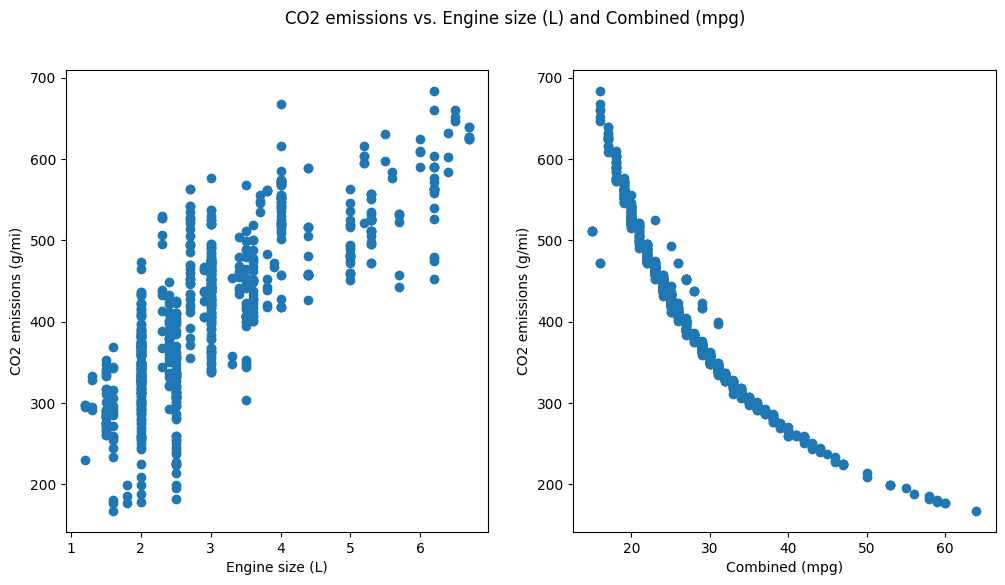

In [7]:
# Scatter plot of CO2 emissions and predictors
fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].scatter(car['Engine_size_L'], car['CO2_emissions_gmi'])
axes[0].set_xlabel('Engine size (L)')
axes[0].set_ylabel('CO2 emissions (g/mi)')

axes[1].scatter(car['Combined_mpg'], car['CO2_emissions_gmi'])
axes[1].set_xlabel('Combined (mpg)')
axes[1].set_ylabel('CO2 emissions (g/mi)')

plt.suptitle('CO2 emissions vs. Engine size (L) and Combined (mpg)')
plt.show()

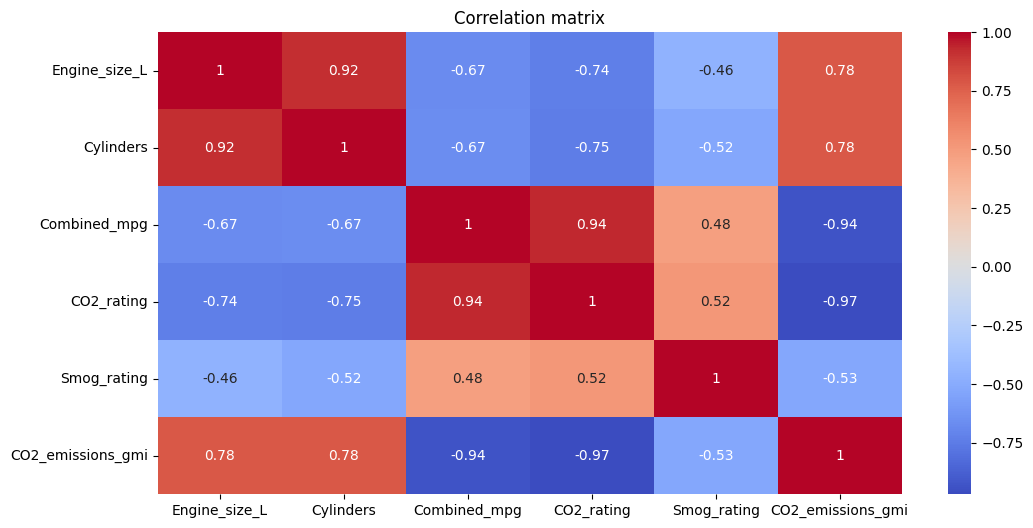

In [8]:
# Correlation matrix of predictors
plt.figure(figsize=(12,6))
corr_matrix = car[['Engine_size_L','Cylinders','Combined_mpg','CO2_rating','Smog_rating','CO2_emissions_gmi']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

## **Multiple Linear Regression - Model Selection**

**For this multiple linear regression model, I begin by comparing the Combined (mpg) variable to the negative exponent of the variable to see if that produces better linear results forbased on the relationship with the CO2 emissions variable in the scatter plot above. Then, I work through a forward selection process to build a multiple linear regression model on the training dataset before testing the best model with each number of predictors on the test dataset. I also did more of a stepwise selection than true forward selection, checking p-values and removing cariables that appeared less significant as features were added.**

In [9]:
# Split data into training and test sets
train_car, test_car = train_test_split(car, train_size = 0.8, random_state = 0)

In [10]:
# Compare regular fuel economy to exp(-fuel economy)
reg = smf.ols('CO2_emissions_gmi ~ Combined_mpg', data=train_car).fit()
exp = smf.ols('CO2_emissions_gmi ~ np.exp(-Combined_mpg)', data=train_car).fit()

print(reg.summary())
print(exp.summary())

                            OLS Regression Results                            
Dep. Variable:      CO2_emissions_gmi   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     4304.
Date:                Mon, 14 Oct 2024   Prob (F-statistic):          5.06e-278
Time:                        15:05:45   Log-Likelihood:                -3050.5
No. Observations:                 610   AIC:                             6105.
Df Residuals:                     608   BIC:                             6114.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      747.8412      5.276    141.750   

In [11]:
# Create list of predictors for the forward selection process
# car.head()
predictors = ['Vehicle_class', 'Engine_size_L', 'Cylinders', 'Transmission', 'Fuel_type', 'Combined_mpg', 'Smog_rating']

In [12]:
# Evaluate all single predictor models
best = ['', 0]
for i in predictors:
  reg = smf.ols('CO2_emissions_gmi ~ ' + i, data=train_car).fit()
  if reg.rsquared_adj > best[1]:
    best = [i, reg.rsquared_adj]

print(best)
reg_1 = smf.ols('CO2_emissions_gmi ~ ' + best[0], data=train_car).fit()
#reg_1.summary()

['Combined_mpg', np.float64(0.8760161549736296)]


In [13]:
# Evaluate all two-predictor models
predictors.remove('Combined_mpg')
best = ['', 0]

for i in predictors:
  reg = smf.ols('CO2_emissions_gmi ~ Combined_mpg + ' + i, data=train_car).fit()
  if reg.rsquared_adj > best[1]:
    best = [i, reg.rsquared_adj]

print(best)
reg_2 = smf.ols('CO2_emissions_gmi ~ Combined_mpg + ' + best[0], data=train_car).fit()
#reg_2.summary()

['Cylinders', np.float64(0.9237929655755567)]


In [14]:
# Evaluate all three-predictor models
predictors.remove('Cylinders')
best = ['', 0]

for i in predictors:
  reg = smf.ols('CO2_emissions_gmi ~ Combined_mpg + Cylinders + ' + i, data=train_car).fit()
  if reg.rsquared_adj > best[1]:
    best = [i, reg.rsquared_adj]

print(best)
reg_3 = smf.ols('CO2_emissions_gmi ~ Combined_mpg + Cylinders + ' + best[0], data=train_car).fit()
#reg_3.summary()

['Transmission', np.float64(0.935382215427053)]


In [15]:
# Evaluate all four-predictor models
predictors.remove('Transmission')
best = ['', 0]

for i in predictors:
  reg = smf.ols('CO2_emissions_gmi ~ Combined_mpg + Cylinders + Transmission + ' + i, data=train_car).fit()
  if reg.rsquared_adj > best[1]:
    best = [i, reg.rsquared_adj]

print(best)
reg_4 = smf.ols('CO2_emissions_gmi ~ Combined_mpg + Cylinders + Transmission + ' + best[0], data=train_car).fit()
#reg_4.summary()

['Fuel_type', np.float64(0.9434033391795196)]


In [16]:
# Evaluate all five-predictor models
predictors.remove('Fuel_type')
best = ['', 0]

for i in predictors:
  reg = smf.ols('CO2_emissions_gmi ~ Combined_mpg + Cylinders + Transmission + Fuel_type + ' + i, data=train_car).fit()
  if reg.rsquared_adj > best[1]:
    best = [i, reg.rsquared_adj]

print(best)
reg_5 = smf.ols('CO2_emissions_gmi ~ Combined_mpg + Cylinders + Transmission + Fuel_type +' + best[0], data=train_car).fit()
#reg_5.summary()

['Vehicle_class', np.float64(0.9468294446102996)]


In [17]:
# Evaluate all six-predictor models
predictors.remove('Vehicle_class')
best = ['', 0]

for i in predictors:
  reg = smf.ols('CO2_emissions_gmi ~ Combined_mpg + Cylinders + Transmission + Fuel_type + Vehicle_class + ' + i, data=train_car).fit()
  if reg.rsquared_adj > best[1]:
    best = [i, reg.rsquared_adj]

print(best)
reg_6 = smf.ols('CO2_emissions_gmi ~ Combined_mpg + Cylinders + Transmission + Fuel_type + Vehicle_class + ' + best[0], data=train_car).fit()
#reg_6.summary()

['Engine_size_L', np.float64(0.9492516053031508)]


## **Results and Analysis**

**To begin analyzing the models that I build through forward selection, I calculated the variance inflation factors for all predictors to check for collinearity. As you can see from the output below, there were a few variables with high collinearity (greater than 5) in the six-predictor model. Like I predicted based on domain knowledge and the correlation metrics, Engine size (L) and Cylinders do appear to have collinearity with each other since they are both measures of how large an engine is. Two of the Fuel types also appear to have high collinearity, so it is best to avoid that variable as well.**

In [18]:
# Check variance inflation factors for six-predictor model
y, X = dmatrices('CO2_emissions_gmi ~ Combined_mpg + Cylinders + Transmission + Fuel_type + Vehicle_class + Engine_size_L', data=train_car, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif[vif['VIF']>5].sort_values(by='VIF', ascending=False)

,VIF,variable
0,260.459151,Intercept
24,24.476613,Fuel_type[T.Z]
23,23.018045,Fuel_type[T.X]
39,10.448483,Engine_size_L
38,10.003714,Cylinders
11,7.967257,Transmission[T.AS8]
37,5.442981,Combined_mpg


**Next, I calculated the adjusted R2 value for both the training and test sets for the models with one through six predictors that I created during the forward selection process. As you can see in the graph below, there is a sharp increase in adjusted R2 when a second predictor is added to the model for both the training and test sets, but this increase quickly levels off for three or more predictors. For this reason, I believe that only two predictors are needed for the model.**

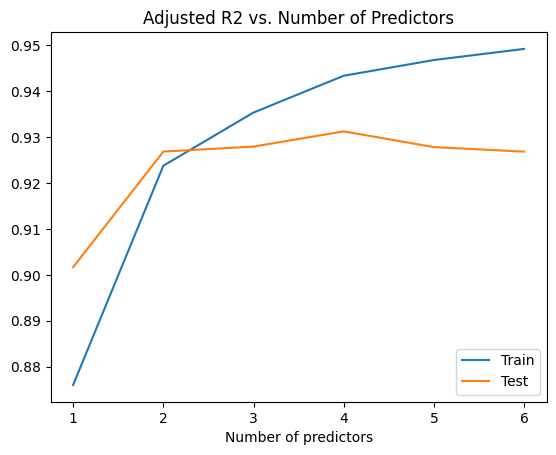

In [19]:
# Compare adjusted R2 for training and test datasets
predictors = list(range(1,7))

models = {
    1: reg_1,
    2: reg_2,
    3: reg_3,
    4: reg_4,
    5: reg_5,
    6: reg_6
}

# Assign training adjusted R2 values
adjr2_train = []
for pred, model in models.items():
  adjr2_train.append(model.rsquared_adj)

# Calculate test adjusted R2 values
adjr2_test = []
y = test_car['CO2_emissions_gmi']
ybar = np.average(y)
sstot = np.sum((y - ybar)**2)

for pred, model in models.items():
  yhat = model.predict(test_car)
  ssres = np.sum((y - yhat)**2)
  r2 = 1 - ssres/sstot
  adj_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - pred - 1)
  adjr2_test.append(adj_r2)

# Plot train and test adjusted R2 values
sns.lineplot(x = predictors, y = adjr2_train, label = 'Train')
sns.lineplot(x = predictors, y = adjr2_test, label = 'Test')
plt.title('Adjusted R2 vs. Number of Predictors')
plt.xlabel('Number of predictors')
plt.legend(loc = 'lower right')
plt.show()

**You could potentially argue for including four variables based on the graph, but when looking at the variance inflation factors for the four-predictor model, the third and fourth predictors both have evidence of multicollinearity, so I believe it is best to exclude them. For the final two-predictor model, there does appear to be some correlation between the predictors, but the variance inflation factor is well under five, so I believe it is okay to include both variables.**

In [20]:
# Check four-predictor model for collinearity
y, X = dmatrices('CO2_emissions_gmi ~ Combined_mpg + Cylinders + Transmission + Fuel_type', data=train_car, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif[vif['VIF']>5].sort_values(by='VIF', ascending=False)

,VIF,variable
0,174.311479,Intercept
24,21.595205,Fuel_type[T.Z]
23,20.078132,Fuel_type[T.X]
11,5.958049,Transmission[T.AS8]


In [21]:
# Check final two-predictor model for collinearity
print(variance_inflation_factor(train_car[['Combined_mpg', 'Cylinders']].values, 1))
print(reg_2.summary())

# Compare to model with interactions
reg_2_int = smf.ols('CO2_emissions_gmi ~ Combined_mpg * Cylinders', data=train_car).fit()
print(reg_2_int.summary())

3.638769995936215
                            OLS Regression Results                            
Dep. Variable:      CO2_emissions_gmi   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     3692.
Date:                Mon, 14 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:06:19   Log-Likelihood:                -2901.5
No. Observations:                 610   AIC:                             5809.
Df Residuals:                     607   BIC:                             5822.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      592.5027      8

## **Conclusion**

**Based on my multilinear regression analysis, I believe that the best predictors of CO2 emissions for consumer vehicles are the combined gas mileage (mpg) and the number of cylinders in the car's engine. The gas mileage alone in a model has an adjusted R2 value of 0.876, so it is a very strong predictor alone of CO2 emissions, which makes sense since the amount of emissions depends heavily on the amount of fuel a car is burning. The signs on both variable's coefficients also make sense intuitively. Based on this model, a car with a 1 mpg increase in its combined gas mileage would emit 9.6 less grams of CO2 per mile on average. Additionally, increasing the number of cylinders in a car by 1 while holding the gas mileage constant would result in an increase of 15.8 grams of CO2 per mile on average. Hopefully this model, while it may not account for all factors that significantly impact CO2 emissions of a vehicle, provides consumers an easy way of being conscious of their carbon footprint while deciding on their next car.**